In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
from diffusion.unet import SinusoidalPositionalEncoding, PositionalEncoding

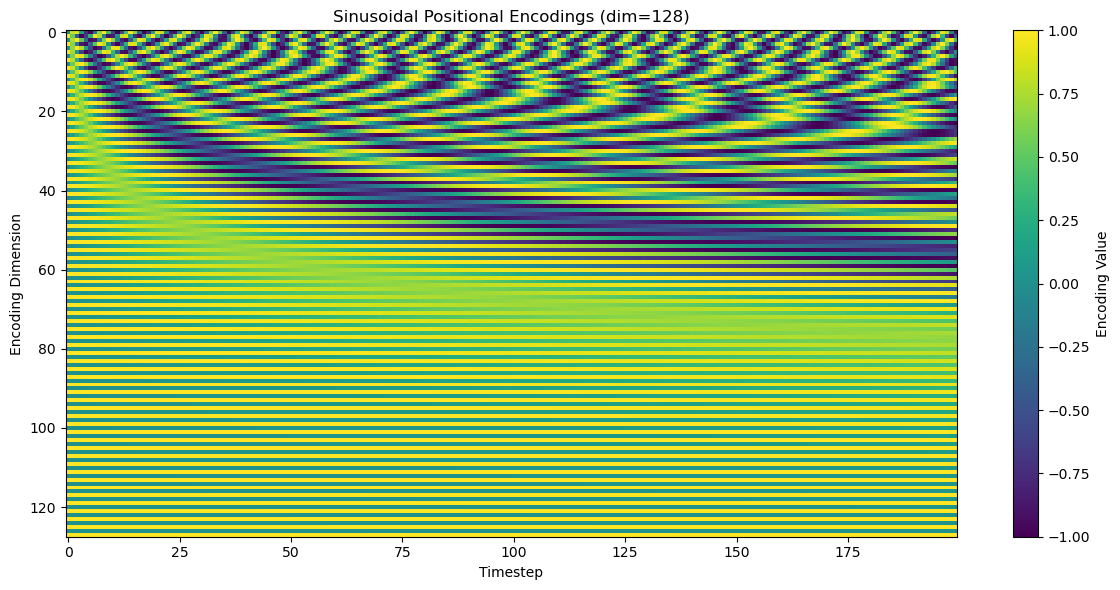

In [9]:
base_dim = 128
timesteps = 200
s = SinusoidalPositionalEncoding(base_dim)
t = torch.arange(0, timesteps)
encodings = s.forward(t)

# Convert to numpy for plotting
encodings_np = encodings.numpy()

# Create the plot
plt.figure(figsize=(12, 6))

# Create heatmap
im = plt.imshow(encodings_np.T, aspect='auto', cmap='viridis')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Encoding Value')

# Customize axes
plt.xlabel('Timestep')
plt.ylabel('Encoding Dimension')
plt.title(f'Sinusoidal Positional Encodings (dim={base_dim})')

# Show plot
plt.tight_layout()
plt.show()


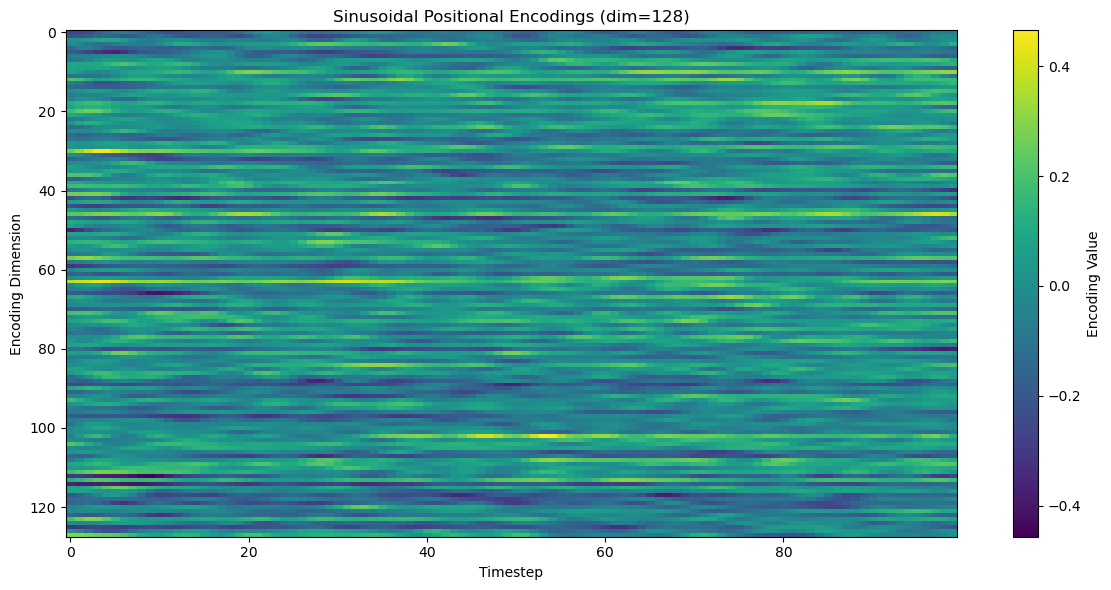

In [4]:
base_dim = 128
timesteps = 100
s = PositionalEncoding(base_dim, base_dim, base_dim)
t = torch.arange(0, timesteps)
encodings = s.forward(t)

# Convert to numpy for plotting
encodings_np = encodings.detach().numpy()
encodings_np = encodings_np[: , :base_dim]

# Create the plot
plt.figure(figsize=(12, 6))

# Create heatmap
im = plt.imshow(encodings_np.T, aspect='auto', cmap='viridis')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Encoding Value')

# Customize axes
plt.xlabel('Timestep')
plt.ylabel('Encoding Dimension')
plt.title(f'Sinusoidal Positional Encodings (dim={base_dim})')

# Show plot
plt.tight_layout()
plt.show()
